In [125]:
# Standard library imports
import os
import datetime as dt
import matplotlib.pyplot as plt

# Data handling and numerical computations
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from scipy import interpolate

# PyTorch related imports
import torch
import torch.nn as nn
from torch.distributions import Categorical, Normal, kl_divergence
from torch.profiler import profile, record_function, ProfilerActivity
from torchdiffeq import odeint

# Visualization library
import matplotlib.pyplot as plt

# Utilities and custom modules
from itertools import chain
import lib.utils as utils
import lib.models as models
import lib.train_functions as train_functions
import lib.encoders as encoders
from lib.HHS_data import *
import tqdm

# Setting the number of threads for PyTorch and specifying the device
torch.set_num_threads(1)

# root = 'checkpoints/HHS_SIR_Big/'   
# enc.load_state_dict(torch.load(root+'enc_' + '.pth'))
# ode.load_state_dict(torch.load(root+'sir_' + '.pth'))
# dec.load_state_dict(torch.load(root+'dec_' + '.pth'))

def eval(x_in, y_in, t, n_samples = 128, dtype = torch.float32):
    batch_size = x_in.shape[0]
    eps = torch.randn(n_samples, batch_size, n_regions, latent_dim-1, dtype=dtype, device=device)
    ode.clear_tracking()
    mean, std = enc(x_in)
    z = encoders.reparam(eps, std, mean, n_samples, batch_size)
    latent = odeint(ode, z, t, method='rk4', options=dict(step_size = 1.0))
    y_pred = dec(latent[..., :3]).reshape((t.shape[0], n_samples, batch_size, n_regions)).permute(2,1,0,3)

    nll = train_functions.nll_loss(y_pred, y_in).detach().cpu().numpy()
    return nll

things i've added:

ignore grads norms > 300 because https://arxiv.org/pdf/2011.10650.pdf

added cosine KL annealing


    


In [105]:
# Variable
n_qs = 5
window = 42
latent_dim = 6
batch_size = 32
means=[0.8, 0.55]
stds = [0.2, 0.2]
ff_sizes = [64,32]
ili_sizes = [32, 16]
SIR_scaler = [0.1, 0.05, 1.0]
q_sizes=[128, 64]

ls_n_qs = [5, 10]
ls_latent_dim = [6, 8]
ls_batch_size = [32]
ls_means=[[0.8, 0.55]]
ls_stds = [[0.2, 0.2]]
ls_q_sizes = [[128, 64], [256, 128], [128, 64, 32]]
ls_ff_sizes = [[64,32], [32]]
ls_ili_sizes = [[32, 16]]
ls_SIR_scaler = [[0.1, 0.05, 1.0], [0.05, 0.025, 1.0], [0.02, 0.01, 1.0]]
anneals = [0, 1]
epochs = [500]
ls_enc_name = ['Encoder_BiDirectionalGRU', 'Encoder_MISO_GRU', 'Encoder_Back_GRU']

df = pd.DataFrame()
ls = []


for epoch in epochs:
    for n_qs in ls_n_qs:
        for latent_dim in ls_latent_dim:
            for batch_size in ls_batch_size:
                for means in ls_means:
                    for stds in ls_stds:
                        for q_sizes in ls_q_sizes:
                            for ff_sizes in ls_ff_sizes:
                                for ili_sizes in ls_ili_sizes:
                                    for SIR_scaler in ls_SIR_scaler:
                                        for anneal in anneals:
                                            for enc_name in ls_enc_name:
                                                ls.append({'n_qs':n_qs,
                                                       'latent_dim':latent_dim, 
                                                       'means':means, 
                                                       'stds':stds,
                                                       'q_sizes':q_sizes,
                                                       'ff_sizes':ff_sizes, 
                                                       'ili_sizes':ili_sizes, 
                                                       'SIR_scaler':SIR_scaler,
                                                       'anneal':anneal,
                                                       'enc_name':enc_name,
                                                       'epochs':epoch})  


df = pd.DataFrame.from_dict(ls)
df['started'] = np.zeros(df.shape[0])
df['validation_score'] = np.zeros(df.shape[0])
# df['Epochs_done'] = np.zeros(df.shape[0])-1

df.index = np.linspace(0, df.shape[0]-1, df.shape[0]).astype(int)
df.to_csv('validation_scores.csv')                    




In [126]:
import re
from datetime import datetime

import re

def extract_values(file_path, name = 'nll'):
    # Function to extract nll values from log lines
    def extract_nll(line):
    
        try:
            
            match = line.split(name+"': ")[1]
            if ',' in match:
                return float(match.split(',')[0])
            if '}' in match:
                return float(match.split('}')[0])
            return 
        
        except:
            return None

    # Read the log file
    with open(file_path, 'r') as file:
        log_lines = file.readlines()

    # Extract nll values
    nll_values = [extract_nll(line) for line in log_lines if extract_nll(line) is not None]

    return nll_values

In [127]:
def return_param_num(file_path):
    with open(file_path, 'r') as file:
        log_lines = file.readlines()
        
    for line in log_lines:
        try:
            param_num = int(line.split('param num: ')[1].split('\n')[0])
            return param_num
        except:
            pass

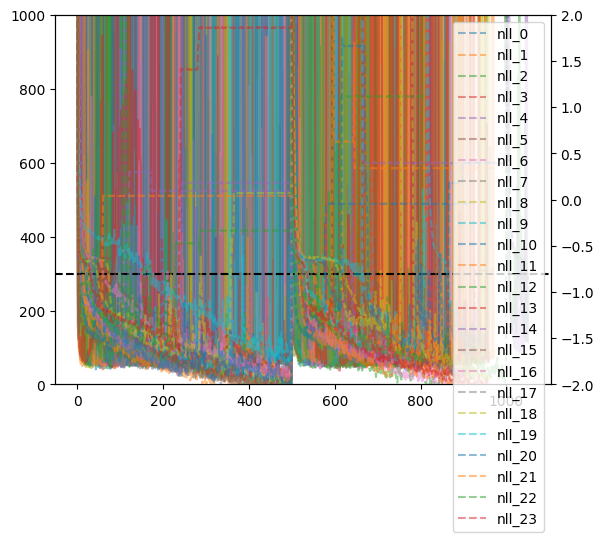

In [128]:
files = ['output_' + str(i) + '.log' for i in range(1, 25)]
nums = [return_param_num(path) for path in files]
files = np.asarray(files)[np.argsort(nums)]

norms = [extract_values(path, name = 'grad_norm') for path in files]
nlls = [extract_values(path, name = 'nll') for path in files]

# Plot grad_norm values
for i, nll in enumerate(nlls):
    plt.plot(norms[i], label=f'nll_{i}', alpha=0.5)
plt.ylim(0, 1000)

# Plot a horizontal line
plt.axhline(y=300, color='black', linestyle='--', label='Threshold')

# Create a second y-axis for nll values
ax2 = plt.gca().twinx()
for i, nll in enumerate(nlls):
    ax2.plot(nll, label=f'nll_{i}', alpha=0.5, linestyle='--')

# Set y-axis limits

ax2.set_ylim(-2, 2)  # Adjust this as needed

# Show legends
plt.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show the plot
plt.show()

In [129]:
def return_model_type(file_path):
    with open(file_path, 'r') as file:
        log_lines = file.readlines()
        
    for line in log_lines:
        try:
            param_num = line.split('enc_name')[1]
            return param_num
        except:
            pass

            Encoder_BiDirectionalGRU

[0, 3, 6, 9, 12, 15, 18, 21]


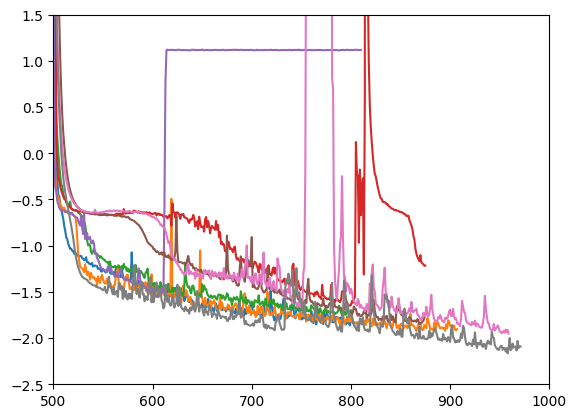

            Encoder_MISO_GRU

[1, 4, 7, 10, 13, 16, 19, 22]


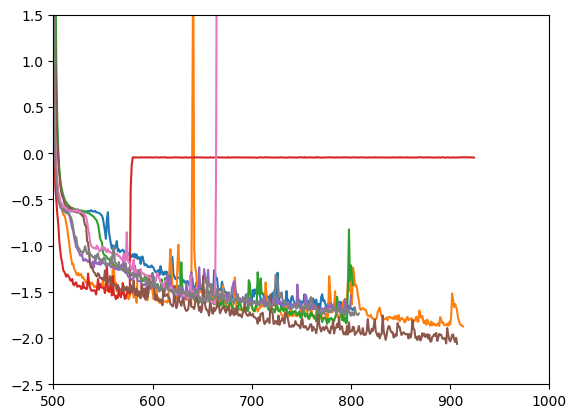

            Encoder_Back_GRU

[2, 5, 8, 11, 14, 17, 20, 23]


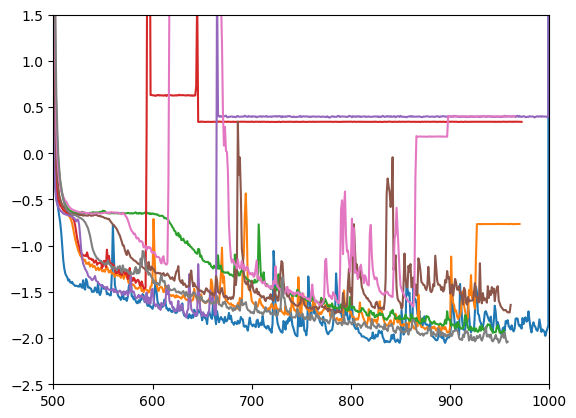

In [130]:
for _ in range(3):
    files = ['output_' + str(i) + '.log' for i in range(1, 25)]
    nums = [return_param_num(path) for path in files]
    files = np.asarray(files)[np.argsort(nums)]

    to_plot = list(np.arange(24).reshape(-1, 3)[:, _])
    files = np.asarray(files)[to_plot]
    
    print(return_model_type(files[0]))
    
    nlls = [extract_values(path, name = 'nll') for path in files]
    print(to_plot)
    for i, nll in enumerate(nlls):
        plt.plot(nll, label = i)
    plt.ylim(-2.5, 1.5)
    plt.xlim(0, 500)
    plt.xlim(500, 1000)
    plt.show()

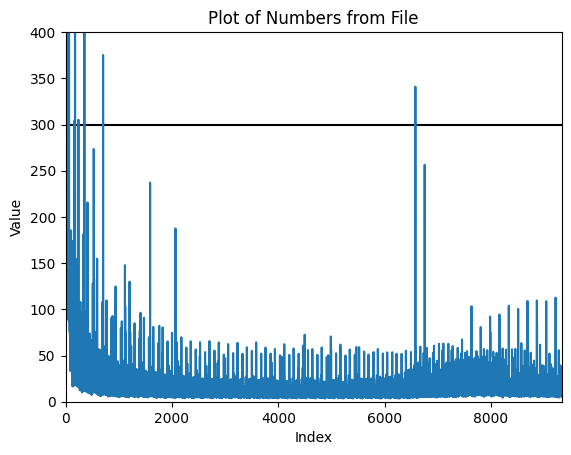

In [184]:


def plot_numbers_from_file(file_path):
    try:
        # Read numbers from the file
        with open(file_path, 'r') as file:
            numbers_str = file.read()

        # Replace newlines with commas and split the string
        numbers_str = numbers_str.replace('\n', ',')
        # Filter out empty strings and convert the rest to floats
        numbers = [float(num) for num in numbers_str.split(',') if num]
        
        plt.plot([0, len(numbers)], [300, 300], color='black')
        # Plot the numbers
        plt.plot(numbers)
        plt.title('Plot of Numbers from File')
        plt.xlabel('Index')
        plt.ylabel('Value')
        plt.ylim(0, 400)
        plt.xlim(0, len(numbers))
        plt.show()

    except FileNotFoundError:
        print(f"File not found: {file_path}")
    except ValueError as e:
        print(f"Error converting string to float: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

# Replace 'your_file.txt' with the actual path to your text file
file_path = 'grad_norms.txt'
plot_numbers_from_file(file_path)


In [28]:
       
df = pd.read_csv('validation_scores.csv', index_col=0)
try:
    param_num = np.min(np.where(df['started'] == 0))
    print(_, param_num)
except:
    print('oh no')
df.loc[param_num, 'started'] = 1

score = 10

params = df.loc[param_num]
# score = evaluate(dict(df.loc[param_num]), disable=True)

n_qs                                                                5
latent_dim                                                          6
means                                                     [0.8, 0.55]
stds                                                       [0.2, 0.2]
q_sizes                                                     [128, 64]
ff_sizes                                                     [64, 32]
ili_sizes                                                    [32, 16]
SIR_scaler                                           [0.1, 0.05, 1.0]
ls_enc_name         ['Encoder_BiDirectionalGRU', 'Encoder_MISO_GRU...
started                                                           1.0
validation_score                                                  0.0
Name: 0, dtype: object 0


[128, 64]

In [29]:

    # n_qs = int(params['n_qs'])
    # latent_dim = int(params['latent_dim'])
    # means = params['means']
    # stds = params['stds']
    # q_sizes = [int(q) for q in params['q_sizes']]
    # ff_sizes = [int(q) for q in params['ff_sizes']]
    # ili_sizes = [int(q) for q in params['ili_sizes']]
    # SIR_scaler = params['SIR_scaler']
    # ls_enc_name = params['ls_enc_name']

    import ast
    n_qs = int(params['n_qs'])
    latent_dim = int(['latent_dim'])
    means = (params['means'])
    stds = (params['stds'])
    q_sizes = [int(q) for q in ast.literal_eval(params['q_sizes'])]
    ff_sizes = [int(q) for q in ast.literal_eval(params['ff_sizes'])]
    
    # Handle potential spaces in the list string
    ili_sizes_str = params['ili_sizes'].replace(' ', ',')
    ili_sizes = [int(q) for q in ast.literal_eval(ili_sizes_str)]


    if enc_name == 'Encoder_BiDirectionalGRU':
        encoder_model = encoders.Encoder_BiDirectionalGRU
    if enc_name == 'Encoder_MISO_GRU':
        encoder_model = encoders.Encoder_MISO_GRU
    if enc_name == 'Encoder_Back_GRU':
        encoder_model = encoders.Encoder_Back_GRU


ValueError: malformed node or string: 5

In [63]:
epochs = 1000
# encoder_model = encoders.Encoder_BiDirectionalGRU
# encoder_model = encoders.Encoder_MISO_GRU
encoder_model = encoders.Encoder_Back_GRU
suppress_outputs = True
lag = 14
n_regions = 10
season = 2016
lr = 1e-3
n_samples = 128


root = 'checkpoints/HHS_SIR_Big_new/'      
device = 'cpu'
dtype=torch.float32

tmax = 8

if encoder_model == encoders.Encoder_Back_GRU:   
    gamma = 28
    t = torch.linspace(1,gamma+window, gamma+window, device=device)/7
    
else:
    gamma = 63
    t = torch.linspace(1,gamma, gamma, device=device)/7
eval_pts = [0,6,13,20,27,34,40,47,54][:tmax]

ili = load_ili('hhs')
ili = intepolate_ili(ili)

hhs_dict = {}
qs_dict = {}

ignore = ['AZ', 'ND', 'AL', 'RI', 'VI', 'PR']
for i in range(1,1+n_regions):
    hhs_dict[i] = get_hhs_query_data(i, ignore=ignore, smooth_after = True)
    qs_dict[i] = choose_qs(hhs_dict, ili, i, season, n_qs)

    hhs_dict[i] = hhs_dict[i].loc[:, list(qs_dict[i])]
    hhs_dict[i] = hhs_dict[i].div(hhs_dict[i].max())
    
ili = ili.loc[hhs_dict[i].index[0] : hhs_dict[i].index[-1]]
ili = ili.div(ili.max())

run_backward = False
if encoder_model == encoders.Encoder_Back_GRU:
    run_backward = True


# Build inputs
inputs = []
outputs = []
for batch in range(ili.shape[0] - (window+gamma)):
    batch_inputs = []
    for i in range(1,11):
        batch_inputs.append(hhs_dict[i].iloc[batch:batch+window])
    
    t_ili = ili.iloc[batch:batch+window].copy()
    t_ili.iloc[-lag:, :] = -1
    batch_inputs.append(t_ili)
    batch_inputs = np.concatenate(batch_inputs, -1)

    if run_backward:
        gamma = 28
        batch_outputs = ili.iloc[batch:batch+window-lag+gamma].values
        t = torch.linspace(1, batch_outputs.shape[0], batch_outputs.shape[0])/7
    else:
        gamma = 56
        batch_outputs = ili.iloc[batch+window-lag:batch+window-lag+gamma].values
        t = torch.linspace(1, batch_outputs.shape[0], batch_outputs.shape[0])/7
        
    inputs.append(batch_inputs)
    outputs.append(batch_outputs)
inputs = torch.tensor(np.asarray(inputs), dtype=torch.float32)
outputs = torch.tensor(np.asarray(outputs), dtype=torch.float32)


# Load models
enc = encoder_model(n_regions, 
             n_qs=n_qs,
             latent_dim = latent_dim-1,    
             q_sizes=q_sizes, 
             ili_sizes=ili_sizes, 
             ff_sizes = ff_sizes, 
             SIR_scaler = SIR_scaler, 
             device=device, 
             dtype=torch.float32)

ode = models.Fp(n_regions, latent_dim, nhidden=64)
dec = models.Decoder(n_regions, 3, 1, device=device)

enc.to(device)
ode.to(device)
dec.to(device)

if not suppress_outputs:
    num = np.sum([np.prod(_.shape) for _ in list(enc.parameters())])
    print('encoder parameters:', num)
    
    num = np.sum([np.prod(_.shape) for _ in list(ode.parameters())])
    print('ode parameters:', num)
    
    num = np.sum([np.prod(_.shape) for _ in list(dec.parameters())])
    print('decoder parameters:', num)

batch_size = 32
new_inputs = torch.tensor(np.asarray(inputs), dtype=torch.float32).to(device)
new_outputs = torch.tensor(np.asarray(outputs), dtype=torch.float32).to(device)

train_size = len(new_inputs) - 365
x_tr, y_tr = new_inputs[:train_size], new_outputs[:train_size]
x_test, y_test = new_inputs[train_size:], new_outputs[train_size:]

# batch it all 
x_train = []
y_train = []
for b in range(int(np.ceil(x_tr.shape[0]/batch_size))):
    x_train.append(torch.tensor(x_tr[b*batch_size:(b+1)*batch_size], dtype=torch.float32))
    y_train.append(torch.tensor(y_tr[b*batch_size:(b+1)*batch_size], dtype=torch.float32))

# pre train
optimizer = torch.optim.Adam(enc.parameters(), lr=lr)
for epoch in range(3):
    kls = 0
    pbar = tqdm.tqdm(x_train, disable=suppress_outputs)
    num = 0
    for x_tr in pbar:
        optimizer.zero_grad()
        
        mean, std = enc(x_tr)
        prior = encoders.make_prior(mean, latent_dim=latent_dim, device=device)
        kl = kl_divergence(Normal(mean, std), prior).mean(0).sum()
        if torch.isnan(kl):
            break
        kl.backward()
        optimizer.step()
        kls += kl.cpu().detach().numpy()
        num += 1
        pbar.set_postfix({'Epoch':epoch, 'KL_z':kls/num})


optimizer = torch.optim.Adam(chain(enc.parameters(), ode.parameters(), dec.parameters()), lr=lr)
_history = train_functions.history()

for epoch in range(epochs):
    pbar = tqdm.tqdm(zip(x_train, y_train), disable=suppress_outputs)
    for x_tr, y_tr in pbar:
        batch_size = x_tr.shape[0]
        eps = torch.randn(n_samples, batch_size, n_regions, latent_dim-1, dtype=dtype, device=device)
        ode.clear_tracking()
        optimizer.zero_grad()
        
        mean, std = enc(x_tr)
        z = encoders.reparam(eps, std, mean, n_samples, batch_size)
        latent = odeint(ode, z, t, method='rk4', options=dict(step_size = 1.0))
        y_pred = dec(latent[..., :3]).reshape((-1, n_samples, batch_size, n_regions)).permute(2,1,0,3)

        # nll = train_functions.nll_loss(y_pred, y_tr[:, eval_pts, :])
        nll = train_functions.nll_loss(y_pred, y_tr)
        kl_p = train_functions.get_kl_params(1, ode.posterior(), means=means, stds = stds,limit = 1e6, device=device)
        kl_z = kl_divergence(encoders.make_prior(mean, latent_dim=latent_dim, device=device), Normal(mean, std)).sum(-1).mean() / len(x_train)
        reg_loss = train_functions.latent_init_loss(latent[..., :3])

        loss = nll+kl_p+kl_z+reg_loss
        loss.backward()
        optimizer.step()
        _history.batch([loss.cpu(), nll.cpu(), kl_z.cpu(),kl_p.cpu(),reg_loss.cpu(), optimizer.param_groups[-1]['lr']], ['loss', 'nll', 'kl_latent', 'kl_params', 'reg_loss', 'lr'])
        pbar.set_postfix(_history.epoch())
    _history.reset()
        
    utils.update_learning_rate(optimizer, 0.999, lr/10)

val_nll = eval(x_test, y_test, t, n_samples = 128, dtype = torch.float32)

/data0/mimorris/torch/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/data0/mimorris/torch/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [11]:
val_nll

array(5.6081266, dtype=float32)